### To use the original numbering of the MACCS keys (1-166) (rather than 0-165), the MACCS keys were implemented to be 167-bit-long, with Bit 0 being always zero. Because Bit 0 is set to OFF for all compounds, it does not affect the evaluation of molecular similarity.

### Therefore feature 0 is always 0 and therefore feature 1 = bit 1 (Isotope), 

In [1]:
import sys
import os

from pathlib import Path
import shap
shap.initjs()
# from pathlib import Path
# import pandas as pd
# import warnings

# from rdkit import Chem, DataStructs
# from rdkit.Chem import (
#     PandasTools,
#     Draw,
#     Descriptors,
#     MACCSkeys,
#     rdFingerprintGenerator,
# )
from rdkit.Chem import rdFMCS
from IPython.display import display
# Add the Regression sister folder to sys.path
regression_folder_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Regression'))
sys.path.append(regression_folder_path)

# Import modules
from Regression_variables import *

#For 3D displays
from molSimplify.Classes.mol3D import mol3D
from molSimplify.Informatics.jupyter_vis import view_structures

# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"


2024-08-02 15:51:37.642059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Assign cluster ID


  0%|          | 0/595 [00:00<?, ?it/s][15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPRECATION WARNING: please use MorganGenerator
[15:51:58] DEPREC

### Use random forrest, random split and TPE sampler w/ best params
### n_est = 323
### max_depth = 8 #not too deep so as to avoid overfitting
### min_sample_split = 2
### min_sample_leaf = 1
### x_train_strat, x_test_strat, y_train_strat, y_test_strat = strat_pIC50_split(compounds)


# SHAP Values

In [2]:
best_n_estimators_rand_TPE = 323
best_max_depth_rand_TPE = 8
best_min_samples_split_rand_TPE = 2
best_min_samples_leaf_rand_TPE = 1


rfr_rand_best_TPE = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand_TPE, max_depth=best_max_depth_rand_TPE, min_samples_split=best_min_samples_split_rand_TPE, min_samples_leaf=best_min_samples_leaf_rand_TPE)
rfr_rand_best_TPE.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
y_pred_rfr_rand_best_TPE = rfr_rand_best_TPE.predict(np.array(list((x_test_rand))).astype(float))

mae_rfr_rand_best_TPE = mean_absolute_error(y_test_rand, y_pred_rfr_rand_best_TPE)
mse_rfr_rand_best_TPE = mean_squared_error(y_test_rand, y_pred_rfr_rand_best_TPE)
r2_rfr_rand_best_TPE = r2_score(y_test_rand, y_pred_rfr_rand_best_TPE)

In [3]:
explainer = shap.Explainer(rfr_rand_best_TPE)
shap_values = explainer(np.array(list((x_train_rand))).astype(float))

In [4]:
np.shape(shap_values.values)
#MACCS keys are 166bit structural key descriptors

(476, 167)

# Waterfall Plot
### This tells us the waterfall plot for the first observation LHS 0 and 1 show the actual value of obs 1. Feature # tells us the MACCS bit we are looking at. The arrow tells us how the feature has contributed to the pIC50 prediction

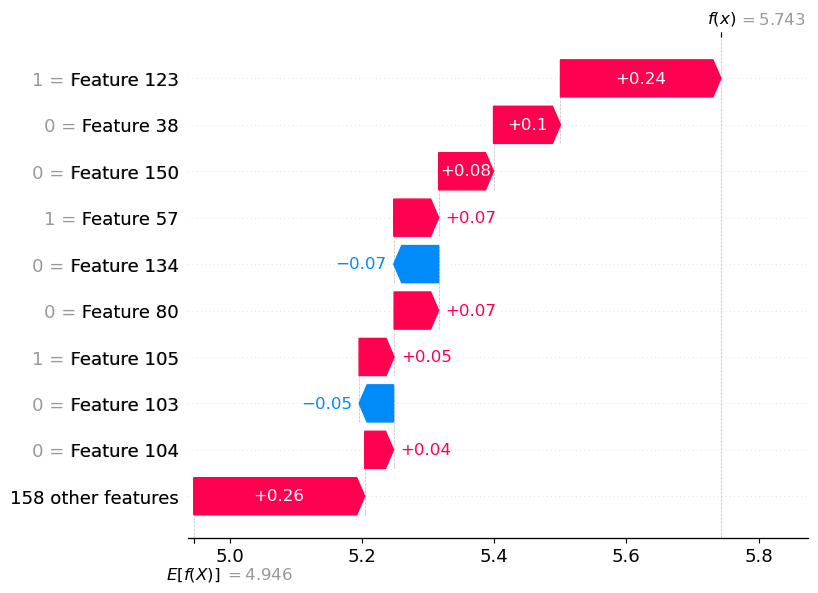

In [5]:
shap.plots.waterfall(shap_values[0])


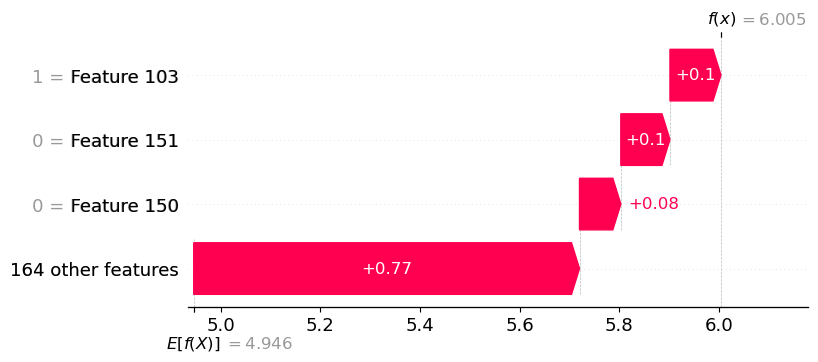

In [6]:
shap.plots.waterfall(shap_values[1], max_display=4)

# Force Plot

In [7]:
# a consended waterfall plot
shap.plots.force(shap_values[0])

# Stacked force plot
### Each of the individual force plots has been flipped 90 degrees and stacked side by side (vertically)

In [8]:
shap.plots.force(shap_values[0:100])

# Absolute Mean SHAP Plot
### Which features are most important to the MODEL
### Each bar gives absolute mean SHAP value for each feature. Features that have made large positive or negative contributions are at the top. 

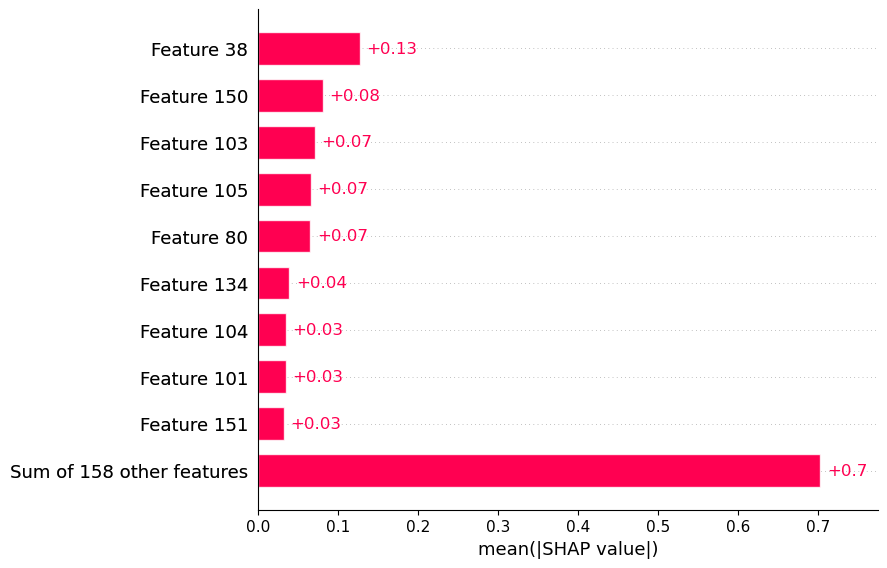

<Figure size 640x480 with 0 Axes>

In [9]:
shap.plots.bar(shap_values)
# save figure
plt.savefig('shap_plt_ABS_rand_TPE.png', dpi=300, bbox_inches='tight')

# Beeswarm Plot
### A visualisation of all of the SHAP values
### y axis: Feature #
### x axis: SHAP value
### colour: determined by the feature values 
### We can see which features have large positive or large negative SHAP values. Features have been ordered in same order in abs mean plot
### There is no gradient here as the feature value is binary [0,1]
### Feature 38: a value of 1 contributes to a negative SHAP value whilse for feature 103 this is the opposite. 

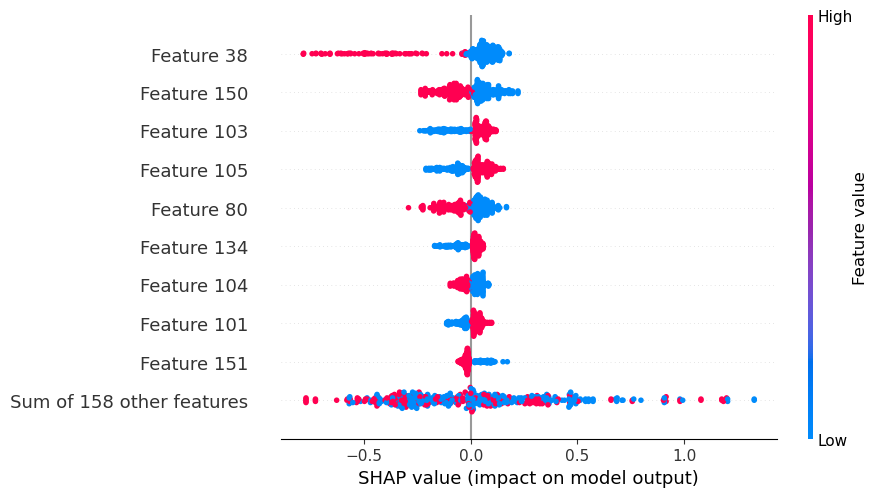

<Figure size 640x480 with 0 Axes>

In [10]:
shap.plots.beeswarm(shap_values)
# save figure
plt.savefig('shap_plt_beeswarm_rand_TPE.png', dpi=300, bbox_inches='tight')

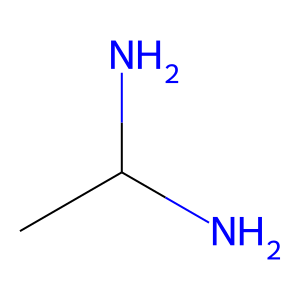

In [11]:
f38_smiles = 'NC(C)N'
f38_molecule = Chem.MolFromSmiles(f38_smiles)
Draw.MolToImage(f38_molecule)

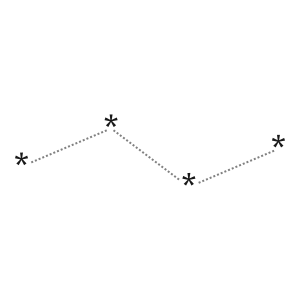

In [12]:
f105_smiles = '[*]~[*]~[*]~[*]'
f105_molecule = Chem.MolFromSmiles(f105_smiles)
Draw.MolToImage(f105_molecule)

In [13]:
# get the smiles string of the 5 molecules with the highest pIC50 values in the column compounds["f_avg_pIC50"]
top_molecules_df = compounds.sort_values(by="f_avg_pIC50", ascending=False).head(12)
top_SMILES = top_molecules_df["SMILES"].to_list()
top_CIDs = top_molecules_df["CID"].to_list()

# Generate the molecule objects from the SMILES strings
top_molecules = [Chem.MolFromSmiles(smiles) for smiles in top_SMILES]


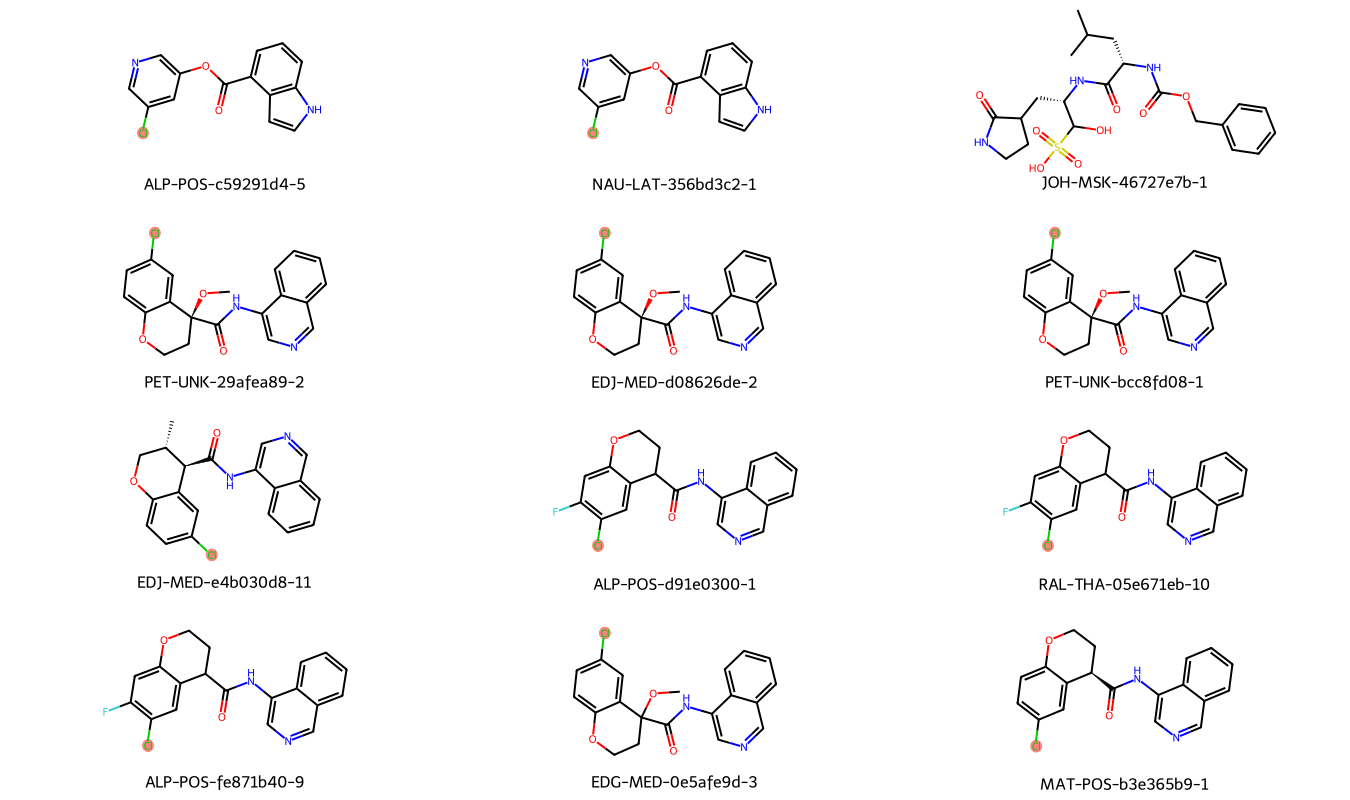

In [14]:
highlight103 = Chem.MolFromSmarts("Cl")
img103 = Draw.MolsToGridImage(
    top_molecules,
    molsPerRow=3,
    subImgSize=(450, 200),
    legends=top_CIDs,
    highlightAtomLists=[molecule.GetSubstructMatch(highlight103) for molecule in top_molecules],
)
display(img103)

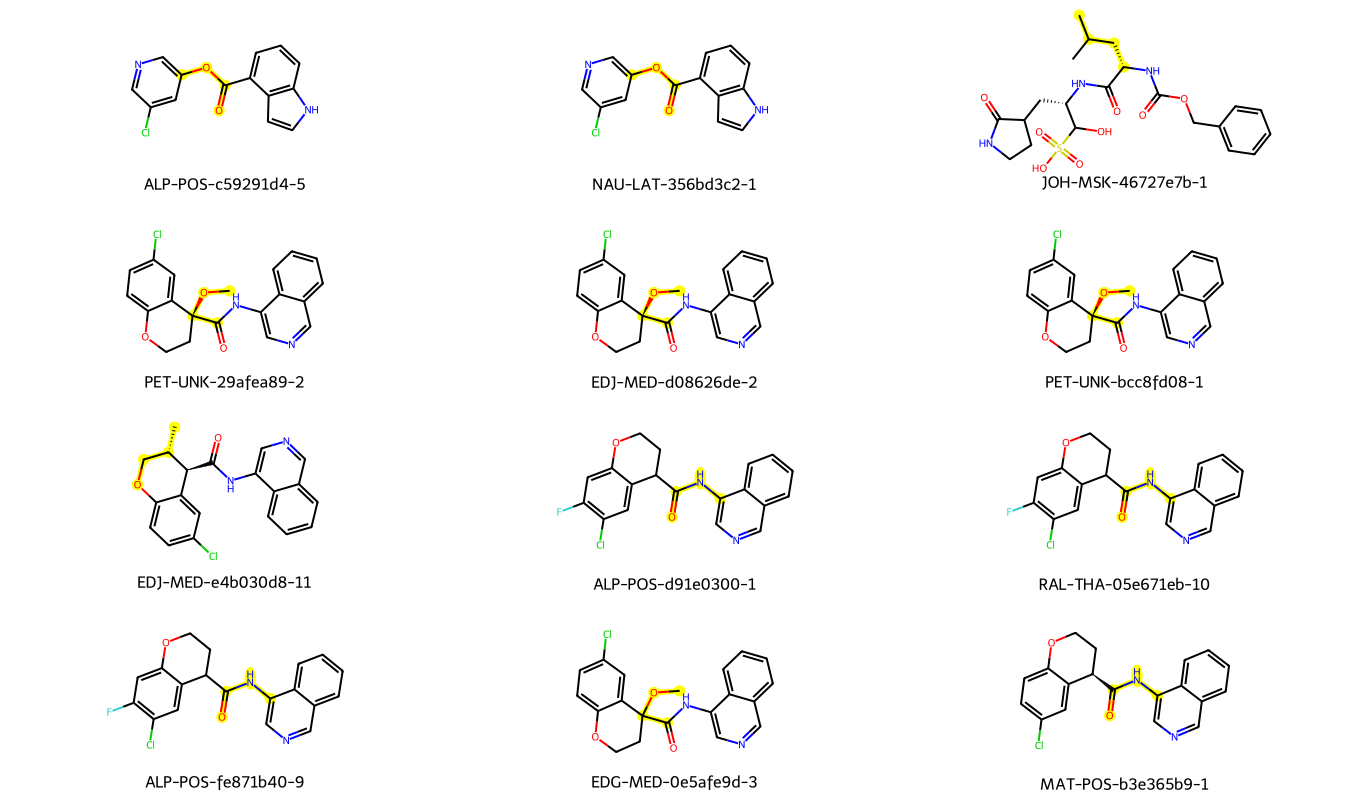

In [15]:
highlight105 = Chem.MolFromSmarts("[*]~[*]~[*]~[*]")
highlight_color = (1.0, 1.0, 0.0)  # RGB for yellow
highlight_atom_lists= [molecule.GetSubstructMatch(highlight105) for molecule in top_molecules]
highlight_atom_lists_colour = [{atom_idx: highlight_color for atom_idx in match} for match in highlight_atom_lists]

img105 = Draw.MolsToGridImage(
    top_molecules,
    molsPerRow=3,
    subImgSize=(450, 200),
    legends=top_molecules_df["CID"].to_list(),
    highlightAtomLists=highlight_atom_lists,
    highlightAtomColors=highlight_atom_lists_colour 
)
display(img105)

# Highlighting the maximum common substructure of the 9 molecules (with highest pIC50 values)

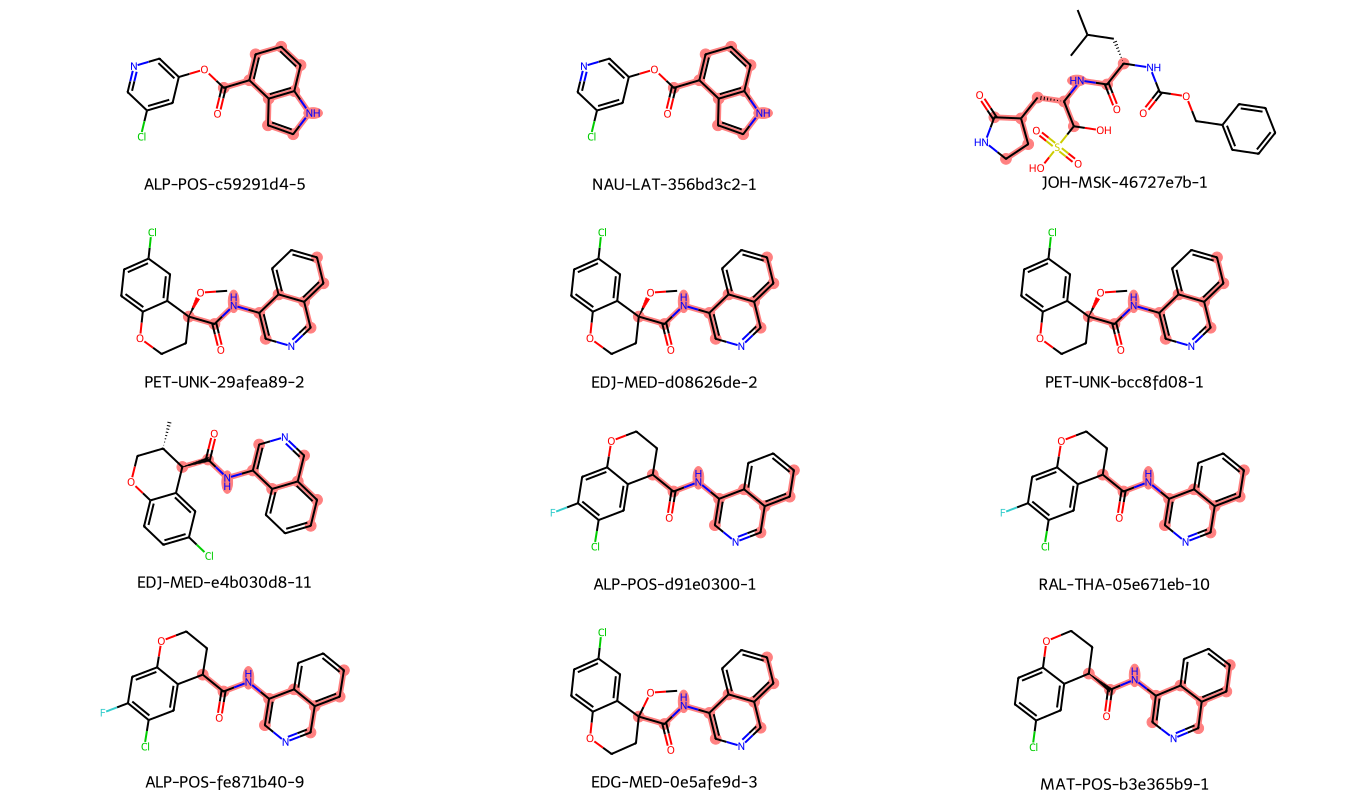

Maximum Common Substructure (MCS) as SMILES: CC(:C:C):C:C(:C):N:C:C


In [16]:
# Find the Maximum Common Substructure (MCS)
mcs_result = rdFMCS.FindMCS(top_molecules)
mcs_smarts = mcs_result.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
legends = top_CIDs

top_highlighted_molecules = []
for mol in top_molecules:
    # Get the atom indices of the MCS in the molecule
    match = mol.GetSubstructMatch(mcs_mol)
    # Highlight the MCS
    top_highlighted_molecules.append((mol, match))

img = Draw.MolsToGridImage(
    [mol for mol, match in top_highlighted_molecules],
    molsPerRow=3,
    subImgSize=(450, 200),
    legends=legends,
    highlightAtomLists=[match for mol, match in top_highlighted_molecules]
)
display(img)

# Convert the MCS to a SMILES string and print it
mcs_smiles = Chem.MolToSmiles(mcs_mol)
print(f"Maximum Common Substructure (MCS) as SMILES: {mcs_smiles}")

# what is happening to molecule 12?? please check thi!!!

In [22]:
mol3Ds = []

for smiles_string in top_SMILES:
    mymol = mol3D()
    mymol.read_smiles(smiles_string)
    mol3Ds += [mymol]

view_structures(mol3Ds, w=300, h=300, columns=3)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.